In [10]:
import torch
from PIL import Image
import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import *
from torch.utils.data import DataLoader
from torch import nn
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import warnings
import os
import random
import math
from sklearn.neighbors import KDTree

warnings.filterwarnings('ignore')
%matplotlib inline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [11]:
!pip install -q torchinfo
from torchinfo import summary

In [12]:
os.getcwd()

'/content/drive/My Drive/Colab Notebooks/Assignment'

In [ ]:
import os
os.chdir("drive/MyDrive/Colab Notebooks/Assignment")
#os.listdir()

# 1- Data Analysis & Preprocessing:
Examine and visualize samples from each dataset to understand the varying scales of the objects. Preprocess and split each dataset into training, validation, and testing subsets.


## 1.1 Examine and visualize samples from each dataset.

In [14]:
def class_info(main_dir):
  # Give info about number of classes and number of images in each class
   print("Main folder:",main_dir)
   print("Number of classes:",sum([1 for sub_dir in os.listdir(main_dir) if "labels" not in sub_dir]))
   for sub_dir in os.listdir(main_dir):
      if "labels" not in sub_dir:
         path_sub_dir = os.path.join(main_dir,sub_dir)
         num_images=len(os.listdir(path_sub_dir))
         print(f"Number of images in {sub_dir:<10} is: {num_images}")
         filenames=os.listdir(path_sub_dir)

In [15]:
# Iterate over main folders and call class_info
main_dirs=["Sentinel2_partial","FAIR1M_partial","RESISC45_partial"]
for main_dir in main_dirs:
    class_info(main_dir)
    print()

Main folder: Sentinel2_partial
Number of classes: 2
Number of images in Ship       is: 1015
Number of images in NoShip     is: 894

Main folder: FAIR1M_partial
Number of classes: 3
Number of images in Neighborhood is: 30
Number of images in Airplane   is: 30
Number of images in Ship       is: 30

Main folder: RESISC45_partial
Number of classes: 3
Number of images in bridge     is: 700
Number of images in ship       is: 700
Number of images in airplane   is: 700



Helper functions to show (optionally random) images.

In [16]:
def show_images( images, num_cols=None, suptitle=None,titles=None,print_shapes=False):
    # Plots the given images
    if num_cols is None:
        num_cols=  8 if len(images)>=8 else len(images)

    if titles is None:
        titles=["" for i in range(len(images))]
    num_rows= int(math.ceil(len(images)/num_cols))

    fig, axs = plt.subplots(num_rows,num_cols,tight_layout=True)

    if num_rows>1:
         axs = axs.flatten()
    elif len(images)==1:
        axs = [axs]

    fig.suptitle(suptitle)
    for  image,ax,title in zip(images,axs,titles):
        ax.imshow(image)
        if title:
          ax.set_title(title)
        ax.set_axis_off()
        if print_shapes:
            print("Image shape:",image.shape)

def get_random_image_paths(main_dir,sub_dir= "labels",num_images=12):
   # if sub_dir is not specified returns image paths from random sub_directory of main_directory
   if sub_dir=="labels":
      while("labels" in sub_dir):
         sub_dir = random.choice(os.listdir(main_dir))

   path_sub_dir = os.path.join(main_dir,sub_dir)
   random_image_filenames= random.choices( os.listdir(path_sub_dir), k=num_images)
   path_random_images =[os.path.join(path_sub_dir,filename) for filename in random_image_filenames if filename.endswith(("jpg","jpeg","png","tif"))]
   class_name=sub_dir
   return path_random_images,class_name

def show_random_images(main_dir,sub_dir="labels", num_images=12,num_cols=4,print_shapes=False ):
    # plots random images using "get_random_image_paths" and "show_images"
    path_random_images,class_name = get_random_image_paths(main_dir,sub_dir,num_images)
    images= [plt.imread(path_image) for path_image in path_random_images]
    suptitle= f"Images from the dataset {main_dir} and from the class: {class_name}"
    show_images(images, num_cols=num_cols, suptitle=suptitle,print_shapes=print_shapes)

Examine and visualize a random subfolder from each main folders using helper functions

Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)


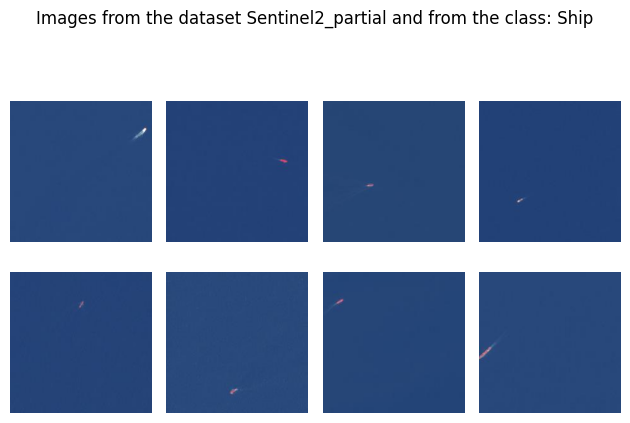

In [17]:
main_dir = main_dirs[0]# Sentinel2_partial
show_random_images(main_dir,num_images=8,print_shapes=True)

Image shape: (1000, 1000, 4)
Image shape: (1000, 1000, 4)
Image shape: (1000, 1000, 4)
Image shape: (1000, 1000, 4)
Image shape: (1000, 1000, 4)
Image shape: (1000, 1000, 4)
Image shape: (1000, 1000, 4)
Image shape: (1000, 1000, 4)


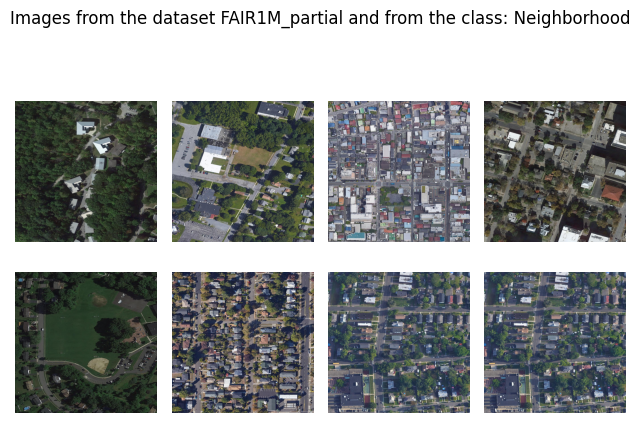

In [18]:
main_dir = main_dirs[1]# "FAIR1M_partial"
show_random_images(main_dir,num_images=8,print_shapes=True)

Image shape: (256, 256, 3)
Image shape: (256, 256, 3)
Image shape: (256, 256, 3)
Image shape: (256, 256, 3)
Image shape: (256, 256, 3)
Image shape: (256, 256, 3)
Image shape: (256, 256, 3)
Image shape: (256, 256, 3)


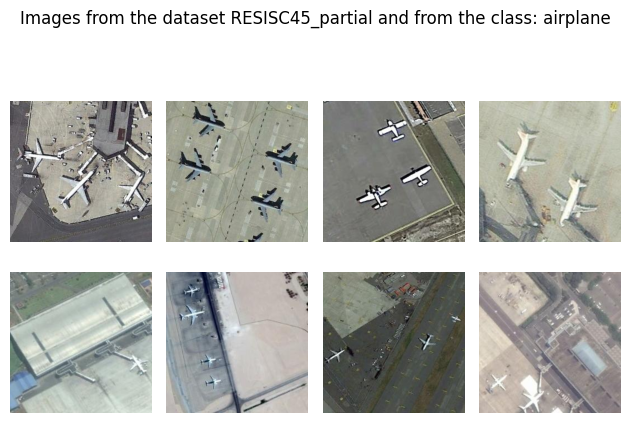

In [20]:
main_dir = main_dirs[2]#RESISC45_partial
show_random_images(main_dir,num_images=8,print_shapes=True)

## 1.2 Merge Folders and Create Image Dataset Folders

Based on the given sample datasets, classes are determined as **ship**, **no-ship**, **airplane**, **bridge**. Neighborhood class is excluded, since
it has very few images.  

In [21]:
class_names = ["ship","noship","airplane","bridge"]

Create **train** and **test** main folders and sub-folders.

In [76]:
if not os.path.exists("train"):
    os.makedirs("train")
    for class_name in class_names:
        os.makedirs("train/"+class_name)

if not os.path.exists("test"):
    os.makedirs("test")
    for class_name in class_names:
        os.makedirs("test/"+class_name)

In [77]:
os.listdir("train"),os.listdir("test")

(['ship', 'noship', 'airplane', 'bridge'],
 ['ship', 'noship', 'airplane', 'bridge'])

**Split original data** and copy to train and test folders.

In [78]:
from sklearn.model_selection import train_test_split
import shutil
def copy_files(from_folder,class_name):
    file_paths = os.listdir(from_folder)
    filenames={}
    filenames["train"], filenames["test"] = train_test_split(file_paths,test_size=0.3)
    for dir in ["train","test"]:
        dir_destination = os.path.join(dir,class_name)
        for filename in filenames[dir]:
                path = os.path.join(from_folder,filename)
                destination = os.path.join(dir_destination)
                shutil.copy(path, destination)

### 1.2.1 Copy files from **Sentinel2_partial**

In [79]:
main_dirs=["Sentinel2_partial","FAIR1M_partial","RESISC45_partial"]
class_info(main_dirs[0])

Main folder: Sentinel2_partial
Number of classes: 2
Number of images in Ship       is: 1015
Number of images in NoShip     is: 894


Copy **Ship** sub-folder to **ship** sub-folders in **train** and **test** directories.

In [80]:
from_folder="Sentinel2_partial/Ship"
copy_files(from_folder,class_name="ship")

Copy **NoShip** sub-folder to **noship** sub-folders in **train** and **test** directories.

In [81]:
len(os.listdir("train/ship"))+len(os.listdir("test/ship")) == len(os.listdir(from_folder))

True

Copy **NoShip** folder

In [82]:
from_folder="Sentinel2_partial/NoShip"
copy_files(from_folder,class_name="noship")

In [83]:
len(os.listdir("train/noship"))+len(os.listdir("test/noship")) == len(os.listdir(from_folder))

True

### 1.2.2 Copy files from **FAIR1M_partial**

In [84]:
class_info(main_dirs[1])

Main folder: FAIR1M_partial
Number of classes: 3
Number of images in Neighborhood is: 30
Number of images in Airplane   is: 30
Number of images in Ship       is: 30


In [85]:
from_folder = "FAIR1M_partial/Airplane"
copy_files(from_folder,class_name="airplane")
from_folder = "FAIR1M_partial/Ship"
copy_files(from_folder,class_name="ship")

### 1.2.3 Copy files from **RESISC45_partial**

In [86]:
class_info(main_dirs[2])

Main folder: RESISC45_partial
Number of classes: 3
Number of images in bridge     is: 700
Number of images in ship       is: 700
Number of images in airplane   is: 700


In [87]:
from_folder = "RESISC45_partial/bridge"
copy_files(from_folder,class_name="bridge")
from_folder = "RESISC45_partial/ship"
copy_files(from_folder,class_name="ship")
from_folder = "RESISC45_partial/airplane"
copy_files(from_folder,class_name="airplane")

# 2- Finetune model based on selected classes


**Assignment Description**: "Choose and/or modify pre-trained models suitable for extracting features from images with varying object scales. The link for the available pretrained models can be found in the Resources section. You can of course always choose to build your own model if you prefer.

Implement a CBIR system which consists of feature representation, feature indexing and feature similarity measuring (Hint: simple KDTree will suffice for feature indexing)."


Initially I tried AID pre-trained model. Then considering dataset sizes and target classes I decided to use RESISC45 pre-trained model.

### 2.1 Adapt the model and load pre-trained weights

In [115]:
#checkpoint = torch.load("aid_pretrained_imagenet1K_efficientnetb0.pth.tar",map_location=device )
checkpoint = torch.load("resisc45_pretrained_imagenet1K_efficientnetb0.pth.tar",map_location=device )

Check pre-trained model's output shape

In [116]:
checkpoint["state_dict"]["classifier.1.weight"].shape,   checkpoint["state_dict"]["classifier.1.bias"].shape

(torch.Size([45, 1280]), torch.Size([45]))

Pre-trained model is trained for 45 classes.

### Examine the original model

Load the original architecture and examine architecture

In [117]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_efficientnet_b0 = torchvision.models.efficientnet_b0()
#model #show all layers

Print the top layer of the original architecture

In [118]:
list(model_efficientnet_b0.children())[-1]

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

Change the top layer of the original model to adapt (match) to the pre-trained model <br>(change the number of output units to the AID pre-trained model's number of classes which is 30)

In [119]:
model_efficientnet_b0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,  out_features=45)).to(device)

Load the weights of pre-trained model and remove the top layer.

In [120]:
model_efficientnet_b0.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

### 2-2 Fine tune the model

Replace top layer for four classes.

In [121]:
model_efficientnet_b0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,  out_features=4)).to(device)

Check model

In [ ]:
#model_efficientnet_b0

Number of layers

In [122]:
len(list(model_efficientnet_b0.named_parameters()))

213

Block containing the conv layer to to fine tune features

In [123]:
list(model_efficientnet_b0.children())[0][-1]

Conv2dNormActivation(
  (0): Conv2d(320, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (1): BatchNorm2d(1280, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): SiLU(inplace=True)
)

Freeze the bottom layers before the block above.(it is  determined as the last 5th layer,after running the check model code above)

In [124]:
for name,param in list(model_efficientnet_b0.named_parameters())[:-5]:
        param.requires_grad = False

In [125]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)

def get_summary(model):
   return summary(model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        row_settings=["var_names"]
   )

In [99]:
get_summary(model_efficientnet_b0)

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]          [1, 4]                    --                        Partial
├─Sequential (features)                                      [1, 3, 224, 224]          [1, 1280, 7, 7]           --                        Partial
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]          [1, 32, 112, 112]         --                        False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]          [1, 32, 112, 112]         (864)                     False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]         [1, 32, 112, 112]         (64)                      False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]         [1, 32, 112, 112]         --       

Define transforms for efficientnet

In [126]:
resize_size = 256
crop_size = 224
transforms={}
transforms["train"] = Compose([Resize(size=resize_size), RandomHorizontalFlip(),RandomCrop(size=crop_size),
                                  ColorJitter(hue=.05, saturation=.05),RandomRotation(20),RandomAffine(3, scale=(0.95, 1.05)),
                                  ToTensor(),Normalize(mean=(0.485, 0.456, 0.406),  std=(0.229, 0.224, 0.225)) ])

transforms["test"]= Compose([Resize(size=resize_size),CenterCrop(size=crop_size),ToTensor(),
                         Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225)) ])

transforms["inv"]= Compose([ Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                         Normalize(mean = [ -0.485, -0.456, -0.406 ],std = [ 1., 1., 1. ]), ])

Create dataloaders

In [128]:
datasets    = {phase:ImageFolder(phase,transforms[phase]) for phase in ["train", "test"]  }
dataloaders = {phase: DataLoader(datasets[phase], batch_size=4) for phase in ["train","test"] }
dataset_sizes = {phase: len(datasets[phase]) for phase in ['train', 'test']}

class_names = datasets["train"].classes
print(class_names)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

['airplane', 'bridge', 'noship', 'ship']


Train the last layers.

In [129]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'test']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

Considering inputs to the top (classifier) layer as features, remove the top layer.
Outputs of the rest of the model will be features.

In [130]:
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn
import time
from tempfile import TemporaryDirectory
model_efficientnet_b0 = model_efficientnet_b0.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(model_efficientnet_b0.parameters(), lr=0.001, weight_decay=1e-4)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [131]:
model = train_model(model_efficientnet_b0, criterion, optimizer,exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.3082 Acc: 0.9470
test Loss: 2.7916 Acc: 0.4804

Epoch 1/24
----------
train Loss: 0.4409 Acc: 0.8967
test Loss: 2.7855 Acc: 0.3903

Epoch 2/24
----------
train Loss: 0.3718 Acc: 0.9083
test Loss: 2.9706 Acc: 0.4427

Epoch 3/24
----------
train Loss: 0.3620 Acc: 0.9087
test Loss: 2.4071 Acc: 0.4345

Epoch 4/24
----------
train Loss: 0.3406 Acc: 0.9073
test Loss: 2.8516 Acc: 0.4108

Epoch 5/24
----------
train Loss: 0.3373 Acc: 0.9111
test Loss: 3.3105 Acc: 0.4321

Epoch 6/24
----------
train Loss: 0.3071 Acc: 0.9168
test Loss: 3.1899 Acc: 0.4051

Epoch 7/24
----------
train Loss: 1.3558 Acc: 0.5286
test Loss: 1.9494 Acc: 0.3093

Epoch 8/24
----------
train Loss: 0.8086 Acc: 0.6769
test Loss: 1.8601 Acc: 0.3290

Epoch 9/24
----------
train Loss: 0.7031 Acc: 0.7482
test Loss: 1.7833 Acc: 0.3650

Epoch 10/24
----------
train Loss: 0.6300 Acc: 0.7727
test Loss: 1.6968 Acc: 0.3781

Epoch 11/24
----------
train Loss: 0.5634 Acc: 0.8001
test Loss: 1.7620 Acc

In [132]:
model_feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])
model_feature_extractor.to("cpu");

In [133]:
def read_transform_image(path ):
    img = Image.open(path)
    transformed_image = transforms["test"](img).unsqueeze(dim=0)#  Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
    return transformed_image

# 3- Feature Extraction & CBIR Implementation:

Check obtaining features from model_feature_extractor

In [134]:
path_random_images,class_name = get_random_image_paths(main_dir,num_images=4)
model_feature_extractor.eval()
with torch.inference_mode():
    for path in path_random_images:
      transformed_image = read_transform_image(path)
      features =  model_feature_extractor(transformed_image)   #  Make a prediction on image with an extra dimension and send it to the target device
      print("Sample featues: ",features.squeeze())

Sample featues:  tensor([-0.1174, -0.1940, -0.0801,  ...,  0.4018,  0.1361, -0.0645])
Sample featues:  tensor([-0.1639,  0.4154, -0.1774,  ...,  0.7520, -0.1039, -0.1007])
Sample featues:  tensor([ 0.1382,  0.5845,  1.2228,  ..., -0.1166,  0.9347,  0.2538])
Sample featues:  tensor([-0.1655, -0.1194, -0.1827,  ...,  0.0570,  0.3839, -0.0908])


## Create a class for CBIR system

In [135]:
class CBIRSystem:
    def __init__(self, feature_representation_model, path_images,labels,num_features=1280,leaf_size=2,metric="minkowski"):
        self.feature_representation_model = feature_representation_model
        self.num_features=num_features
        self.feature_indexing = self.get_feature_indexing(path_images,leaf_size,metric)
        self.path_images=path_images
        self.labels=labels

    def retrieve(self,distances, indices):
        # retrieves images and labels
        path_images_retrieved = [self.path_images[i] for i in indices]
        labels_retrieved=[self.labels[i] for i in indices]
        print(f"Returned image indices:{indices}")
        print(f"Returned image labels:{labels_retrieved}")
        return path_images_retrieved,labels_retrieved

    def query_image(self, path_query_image, num_results=5):
        #returns retrived images, labels,distances and indices for the given query image path (calls retrieve)
        img = Image.open(path_query_image).convert('RGB')
        transformed_image = transforms["test"](img).unsqueeze(dim=0)
        self.feature_representation_model.eval()
        with torch.inference_mode():
            features = self.feature_representation_model(transformed_image).view(1,-1)
            distances, indices = self.feature_indexing.query(features, k=num_results)
            distances, indices = distances.squeeze(), indices.squeeze()
        path_images_retrieved,labels_retrieved =self.retrieve(distances, indices)

        return  path_images_retrieved,labels_retrieved,distances , indices

    def query_test_by_index(self,index,num_results=5):
        #returns retrived images, labels,distances and indices for the given query image path
        path_query_image,query_label= self.path_images[index],self.labels[index]
        print(f"Index of query image: {index}")
        print(f"Label of the selected image is '{query_label}'.")
        return self.query_image(path_query_image, num_results)

    def get_feature_indexing(self,path_images,leaf_size,metric):
        # returns the feature indexing (KD Tree)
        features_all =np.empty((len(path_images),self.num_features))
        for i,path in enumerate(path_images):
            transformed_image=read_transform_image(path)
            features_img =  self.feature_representation_model(transformed_image).view(1,-1)   #  Make a prediction on image with an extra dimension and send it to the target device
            features_all[i]=features_img.detach().numpy()

        return KDTree(features_all, leaf_size,metric)

In [137]:
def get_image_paths(main_dir):
    # Returns all images (and their labels) in the sub directories of main_dir
    path_images = []
    labels = []
    for sub_dir in os.listdir(main_dir):
        if "labels" not in sub_dir:
            path_sub_dir = os.path.join(main_dir,sub_dir)
            path_images.extend([os.path.join(path_sub_dir,filename) for filename in os.listdir(path_sub_dir) if filename.endswith(("jpg","jpeg","png","tif"))])
            labels.extend([sub_dir]*len(path_images))
    return path_images,labels

In [138]:
path_images,labels = get_image_paths(main_dir)
cbir = CBIRSystem(model_feature_extractor, path_images,labels)

## Query testing

Select a random query image and get CBIR results

In [139]:
random_index = random.randint(0,len(path_images)) # select a random index
path_images_retrieved,labels_retrieved,distances, indices= cbir.query_test_by_index(index=random_index)

Index of query image: 44
Label of the selected image is 'bridge'.
Returned image indices:[ 44 569 415 115 427]
Returned image labels:['bridge', 'bridge', 'bridge', 'bridge', 'bridge']


In [140]:
indices,distances

(array([ 44, 569, 415, 115, 427]),
 array([0.        , 7.04512677, 7.80606403, 7.84864225, 8.12901728]))

Note: First element of the retrieve images is the query image itself. So a slight change is needed : an addition to num_results and slicing from the index 0 should be added.

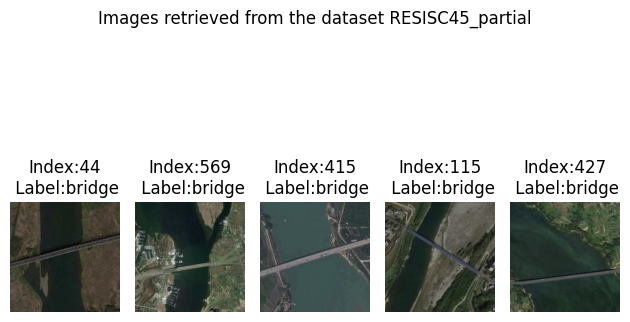

In [142]:
suptitle = f"Images retrieved from the dataset {main_dir}"
titles=[f"Index:{index}\n Label:{label}" for index,label in zip(indices,labels_retrieved)]
images_retrieved = [Image.open(path_image_retrieved) for path_image_retrieved in path_images_retrieved]
show_images(images_retrieved,suptitle=suptitle,titles=titles)

### PostProcessing - GradCam

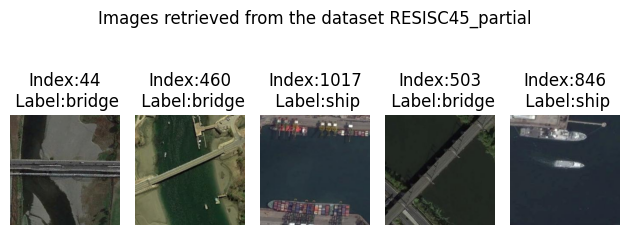

In [ ]:
show_images(images_retrieved,suptitle=suptitle,titles=titles)

In [143]:
model.to("cpu");
model.eval();

In [144]:
class ModelGradCam(nn.Module):
    def __init__(self):
        super().__init__()
        self.features=model.features
        self.avgpool=model.avgpool
        self.classifier =model.classifier
        # placeholder for the gradients
        self.gradients = None

    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.features(x)

        # register the hook
        h = x.register_hook(self.activations_hook)

        # apply the remaining pooling
        x = self.avgpool(x)
        x = x.squeeze()#x.view((1, -1))
        x = self.classifier(x)
        return x

    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients

    # method for the activation exctraction
    def get_activations(self, x):
        return self.features(x)

In [152]:
from torchvision import datasets
from torch.utils import data
# define a 1 image dataset
dataset_query= datasets.ImageFolder(root='RESISC45_partial', transform=transforms["test"] )

# define the dataloader to load that single image
dataloader = data.DataLoader(dataset=dataset_query, shuffle=False, batch_size=1)
img, lbl = next(iter(dataloader))
img.shape,lbl
# initialize the  model
model_grad_cam = ModelGradCam()
preds = model_grad_cam(img)
pred_label=preds.argmax().item()



In [153]:
class_names[pred_label]

'ship'

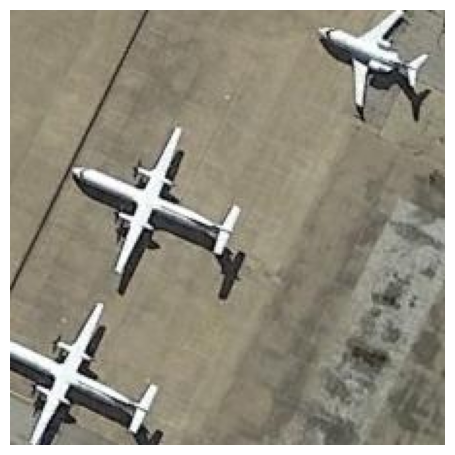

In [ ]:
inv_tensor = transforms["inv"](img)
show_images(inv_tensor.permute(0,2,3,1) )

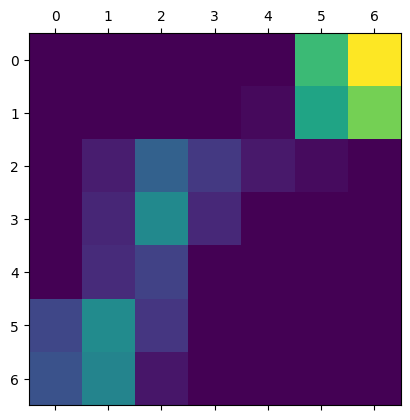

In [ ]:
# get the gradient of the output with respect to the parameters of the model
preds[pred_label].backward()
# pull the gradients out of the model
gradients = model_grad_cam.get_activations_gradient()

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = model_grad_cam.get_activations(img).detach()

# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]

# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())

It can be seen that regions contain Airplane objects are most dominant.

In [ ]:
img.shape

(1, 3, 224, 224)

In [ ]:

import cv2
#img = cv2.imread('./data/Elephant/data/05fig34.jpg')
img_cpy= inv_tensor.permute(0,2,3,1).numpy().squeeze()
heatmap = cv2.resize(heatmap.numpy(), (img_cpy.shape[1], img_cpy.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img_cpy

True

Superimposing makes it more clear that actually objects in the image determine the classification result.

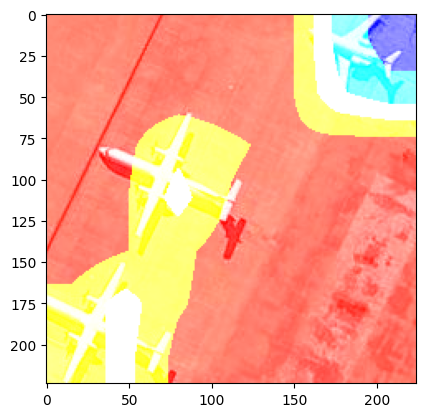

In [ ]:
plt.imshow(superimposed_img)